In [6]:
### Cella 1: Import e Setup dei Percorsi (Corretto per la cartella scripts)

import sys
from pathlib import Path
import numpy as np
import spectral # Assicurati che sia installato
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# --- Impostazione Path di Progetto ---
# La directory corrente è .../scripts/
notebook_dir = Path.cwd() 

# La root del progetto è solo UN livello sopra
PROJECT_ROOT = notebook_dir.parent 
MODULE_PATH = str(PROJECT_ROOT)
# --- Fine Modifica ---

# Aggiungi la ROOT del progetto al path di Python
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    print(f"Aggiunto al path: {MODULE_PATH}")

# Ora gli import funzioneranno
from utils.data_loading import list_all_instances, load_envi_image #
from utils.helpers import setup_logger #

# Definisci i percorsi principali partendo dalla ROOT
DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "hsi_dataset"
PROCESSED_DIR = DATA_DIR / "processed"

print(f"Project Root: {PROJECT_ROOT}")
print(f"Raw Data Path: {RAW_DATA_DIR}")
print(f"Processed Data Path: {PROCESSED_DIR}")

Project Root: /home/ale/repos/HSI-benchmark-eval
Raw Data Path: /home/ale/repos/HSI-benchmark-eval/data/hsi_dataset
Processed Data Path: /home/ale/repos/HSI-benchmark-eval/data/processed


In [7]:
### Cella 2: Costruzione del Catalogo Dati

data_catalog = {}

# 1. Trova tutte le istanze raw usando la tua funzione
raw_instance_paths = list_all_instances(RAW_DATA_DIR) #

for instance_path in raw_instance_paths:
    instance_id = instance_path.name # Es: "004-02"
    processed_path = PROCESSED_DIR / instance_id

    # Popola il catalogo con i percorsi
    data_catalog[instance_id] = {
        "patient_id": instance_id.split('-')[0], #
        "campaign": instance_path.parent.name,
        "raw_path": instance_path,
        "raw_hdr": instance_path / "raw.hdr",
        "raw_data": instance_path / "raw",
        "white_ref_hdr": instance_path / "whiteReference.hdr",
        "dark_ref_hdr": instance_path / "darkReference.hdr",
        "gt_map_hdr": instance_path / "gtMap.hdr",
        "processed_path": processed_path,
        "processed_cube_npy": processed_path / "preprocessed_cube.npy", #
        "processed_gt_npy": processed_path / "gtMap.npy" #
    }

print(f"Catalogo costruito. Trovate {len(data_catalog)} istanze.")
print(f"La prima istanza trovata è: {list(data_catalog.keys())[0]}")

Catalogo costruito. Trovate 61 istanze.
La prima istanza trovata è: 004-02


In [10]:
### Cella 3: Task 1 - Validazione Dimensioni (Raw HDR vs Processed NPY)

print("Avvio Task 1: Comparazione dimensioni (Raw HDR vs Processed NPY)...")

comparison_results = []
mismatch_found = False

for instance_id, paths in data_catalog.items():
    try:
        # 1. Carica metadati RAW
        img_raw = spectral.envi.open(str(paths['raw_hdr']))
        meta_lines = int(img_raw.metadata['lines'])
        meta_samples = int(img_raw.metadata['samples'])
        
        # 2. Carica lo shape del cubo processato (.npy)
        # Usiamo np.load con mmap_mode per leggere solo lo shape senza caricare
        # l'intero array in memoria, ma la lettura dell'header è più efficiente.
        with open(paths['processed_cube_npy'], 'rb') as f:
            version = np.lib.format.read_magic(f)
            # Legge l'header dell'array numpy
            shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
            
        # Lo shape del cubo processato è (bands, lines, samples)
        proc_bands, proc_lines, proc_samples = shape
        
        # 3. Confronta
        line_match = (meta_lines == proc_lines)
        sample_match = (meta_samples == proc_samples)
        
        # 4. Registra i risultati
        status = "✅"
        if not line_match or not sample_match:
            status = "❌ MISMATCH"
            mismatch_found = True
            
        comparison_results.append({
            "instance": instance_id,
            "meta_H_W": f"({meta_lines}, {meta_samples})",
            "proc_H_W": f"({proc_lines}, {proc_samples})",
            "status": status,
            "bands": proc_bands
        })
    
        
    except FileNotFoundError:
        comparison_results.append({
            "instance": instance_id, "meta_H_W": "N/A", "proc_H_W": "N/A",
            "status": "🔥 FILE NON TROVATO", "bands": -1
        })
    except Exception as e:
        print(f"Errore durante processamento {instance_id}: {e}")

# Crea e stampa un DataFrame con i risultati
df_compare = pd.DataFrame(comparison_results)
pd.set_option('display.max_rows', 100)

print(f"\n--- Risultati del Confronto Dimensioni ({len(df_compare)} immagini) ---")
if mismatch_found:
    print("⚠️ ATTENZIONE: Trovate discrepanze! Queste sono normali se lo script di data loading esegue un crop.")
    print(df_compare.to_string())
else:
    print("✅ OTTIMO: Tutte le immagini processate corrispondono alle dimensioni dei metadati raw.")
    print(df_compare.to_string())

Avvio Task 1: Comparazione dimensioni (Raw HDR vs Processed NPY)...

--- Risultati del Confronto Dimensioni (61 immagini) ---
✅ OTTIMO: Tutte le immagini processate corrispondono alle dimensioni dei metadati raw.
   instance    meta_H_W    proc_H_W status  bands
0    004-02  (389, 345)  (389, 345)      ✅    128
1    005-01  (483, 488)  (483, 488)      ✅    128
2    007-01  (582, 400)  (582, 400)      ✅    128
3    008-01  (460, 549)  (460, 549)      ✅    128
4    008-02  (480, 553)  (480, 553)      ✅    128
5    010-03  (371, 461)  (371, 461)      ✅    128
6    012-01  (443, 497)  (443, 497)      ✅    128
7    012-02  (445, 498)  (445, 498)      ✅    128
8    013-01  (298, 253)  (298, 253)      ✅    128
9    014-01  (317, 244)  (317, 244)      ✅    128
10   015-01  (376, 494)  (376, 494)      ✅    128
11   016-01  (335, 323)  (335, 323)      ✅    128
12   016-02  (335, 326)  (335, 326)      ✅    128
13   016-03  (315, 321)  (315, 321)      ✅    128
14   016-04  (383, 297)  (383, 297)  

In [14]:
### Cella 4: Task 2a - Validazione Lunghezze d'onda (Intra-Immagine, SU TUTTE LE IMMAGINI)

print("Avvio Task 2a: Controllo consistenza lunghezze d'onda (raw vs white vs dark) per TUTTE le istanze...")

mismatch_count = 0
file_not_found_count = 0
processed_count = 0

for instance_id, paths in data_catalog.items():
    try:
        # Carica le liste di lunghezze d'onda dai 3 file .hdr
        wl_raw = spectral.envi.open(str(paths['raw_hdr'])).metadata['wavelength']
        wl_white = spectral.envi.open(str(paths['white_ref_hdr'])).metadata['wavelength']
        wl_dark = spectral.envi.open(str(paths['dark_ref_hdr'])).metadata['wavelength']
        
        # Converti in array numpy di float per un confronto robusto
        wl_raw_np = np.array(wl_raw, dtype=float)
        wl_white_np = np.array(wl_white, dtype=float)
        wl_dark_np = np.array(wl_dark, dtype=float)
        
        # Confronta
        raw_vs_white = np.array_equal(wl_raw_np, wl_white_np)
        raw_vs_dark = np.array_equal(wl_raw_np, wl_dark_np)
        
        if not raw_vs_white or not raw_vs_dark:
            print(f"❌ MISMATCH in {instance_id}:")
            if not raw_vs_white:
                print(f"  - Raw ({len(wl_raw_np)} bande) vs White ({len(wl_white_np)} bande) DIVERSI")
            if not raw_vs_dark:
                print(f"  - Raw ({len(wl_raw_np)} bande) vs Dark ({len(wl_dark_np)} bande) DIVERSI")
            mismatch_count += 1
            
        processed_count += 1

    except FileNotFoundError as e:
        print(f"🔥 FILE NON TROVATO per {instance_id}: {e.filename}")
        file_not_found_count += 1
    except Exception as e:
        print(f"Errore generico durante il processamento di {instance_id}: {e}")
        mismatch_count += 1

# --- Riepilogo Finale Task 2a ---
print("\n--- Riepilogo Validazione Intra-Immagine ---")
print(f"Istanze processate: {processed_count}/{len(data_catalog)}")
print(f"Istanze con file mancanti: {file_not_found_count}")
print(f"Istanze con lunghezze d'onda non consistenti: {mismatch_count}")

if mismatch_count == 0 and file_not_found_count == 0:
    print("\nRisultato: ✅ OTTIMO. Tutte le istanze hanno file .hdr consistenti per raw, white e dark.")
else:
    print("\nRisultato: ⚠️ ATTENZIONE. Sono state trovate discrepanze o file mancanti.")

Avvio Task 2a: Controllo consistenza lunghezze d'onda (raw vs white vs dark) per TUTTE le istanze...

--- Riepilogo Validazione Intra-Immagine ---
Istanze processate: 61/61
Istanze con file mancanti: 0
Istanze con lunghezze d'onda non consistenti: 0

Risultato: ✅ OTTIMO. Tutte le istanze hanno file .hdr consistenti per raw, white e dark.


Avvio Task 2b: Controllo omogeneità lunghezze d'onda (tra tutte le immagini)...

--- Analisi Omogeneità (su 61 immagini) ---
✅ Tutte le immagini hanno lo stesso numero di bande: 826
✅ OTTIMO: Tutte le immagini usano ESATTAMENTE lo stesso campionamento di lunghezze d'onda.
   Range: 400.482 nm a 1000.730 nm

--- Generazione Plot (Campionamento Lunghezze d'onda) ---


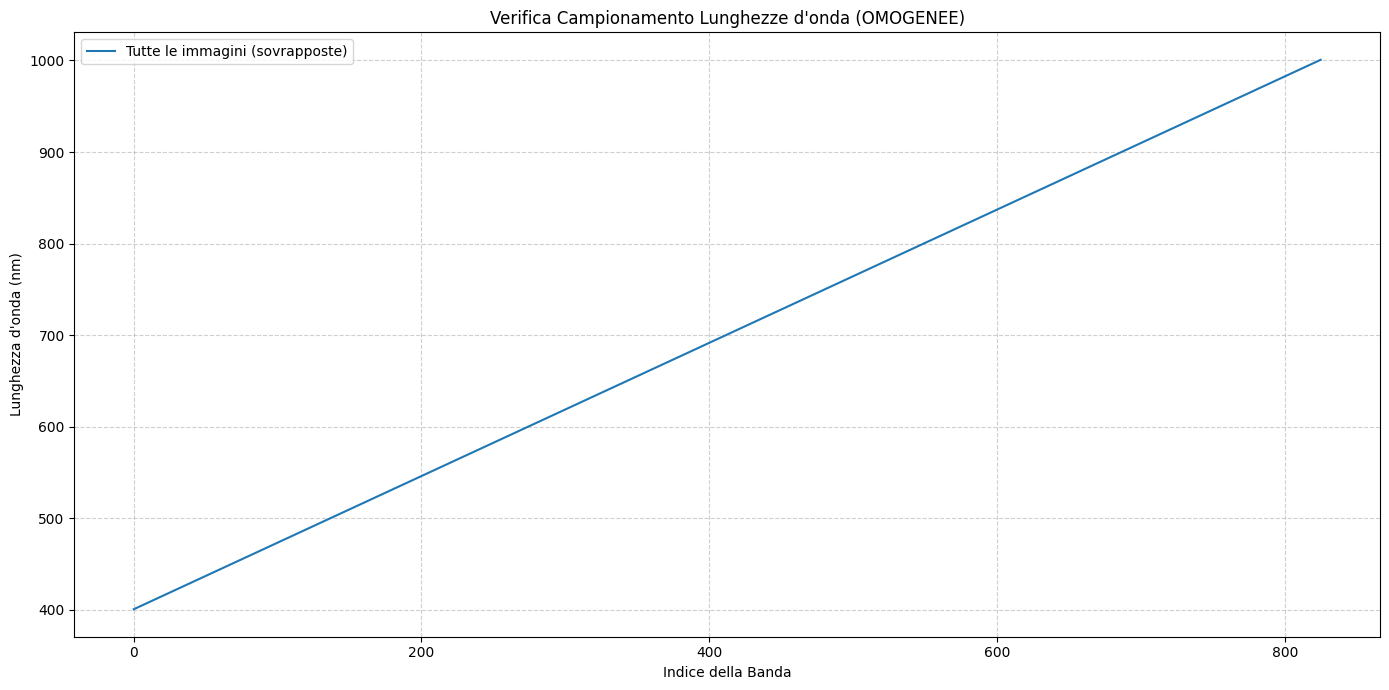

In [13]:
### Cella 5: Task 2b - Validazione Lunghezze d'onda (Inter-Immagine) e Plot

print("Avvio Task 2b: Controllo omogeneità lunghezze d'onda (tra tutte le immagini)...")

wavelength_sets = set()
all_wavelengths_lists = []
band_indices = None
all_bands_count = []

for instance_id, paths in data_catalog.items():
    try:
        # Carica la lista di lunghezze d'onda
        wl_list = spectral.envi.open(str(paths['raw_hdr'])).metadata['wavelength']
        
        # Converti in numpy array di float
        wl_np = np.array(wl_list, dtype=float)
        all_bands_count.append(len(wl_np))
        
        # Salva per il plot e per il confronto
        all_wavelengths_lists.append(wl_np)
        wavelength_sets.add(tuple(wl_np)) # Aggiungi la tupla (hashable) al set
        
    except Exception as e:
        print(f"Errore nel caricamento di {instance_id}: {e}")

# --- Analisi Omogeneità ---
print(f"\n--- Analisi Omogeneità (su {len(all_wavelengths_lists)} immagini) ---")

# Controlla se il numero di bande è lo stesso per tutti
unique_band_counts = set(all_bands_count)
if len(unique_band_counts) == 1:
    print(f"✅ Tutte le immagini hanno lo stesso numero di bande: {list(unique_band_counts)[0]}")
    band_indices = np.arange(list(unique_band_counts)[0])
else:
    print(f"⚠️ ATTENZIONE: Trovati diversi conteggi di bande: {unique_band_counts}")

# Controlla se le lunghezze d'onda sono identiche
if len(wavelength_sets) == 1:
    print("✅ OTTIMO: Tutte le immagini usano ESATTAMENTE lo stesso campionamento di lunghezze d'onda.")
    wl_esempio = all_wavelengths_lists[0]
    print(f"   Range: {wl_esempio[0]:.3f} nm a {wl_esempio[-1]:.3f} nm")
else:
    print(f"⚠️ ATTENZIONE: Trovati {len(wavelength_sets)} diversi campionamenti di lunghezze d'onda tra le immagini.")
    for i, wl_tuple in enumerate(wavelength_sets):
        print(f"  - Set {i+1}: {len(wl_tuple)} bande, da {wl_tuple[0]:.3f} a {wl_tuple[-1]:.3f} nm")
        
# --- Plot ---
print("\n--- Generazione Plot (Campionamento Lunghezze d'onda) ---")

plt.figure(figsize=(14, 7))

# Per evitare un grafico illeggibile, plottiamo solo i set unici
if len(wavelength_sets) > 5:
    print("Trovati >5 campionamenti unici. Plotto solo i primi 5.")
    sets_to_plot = list(wavelength_sets)[:5]
else:
    sets_to_plot = list(wavelength_sets)

for i, wl_tuple in enumerate(sets_to_plot):
    indices = np.arange(len(wl_tuple))
    plt.plot(indices, wl_tuple, label=f"Set {i+1} ({len(wl_tuple)} bande)")

if len(wavelength_sets) == 1:
    plt.title("Verifica Campionamento Lunghezze d'onda (OMOGENEE)")
    plt.legend(["Tutte le immagini (sovrapposte)"])
else:
     plt.title("Verifica Campionamento Lunghezze d'onda (DIVERSE)")
     plt.legend()

plt.xlabel("Indice della Banda")
plt.ylabel("Lunghezza d'onda (nm)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [15]:
### Cella 3: Estrazione delle Dimensioni dai Dati Processati

print("Avvio estrazione dimensioni dai file .npy processati...")

dimensions_list = []

for instance_id, paths in data_catalog.items():
    try:
        # Legge solo l'header del file .npy per efficienza
        with open(paths['processed_cube_npy'], 'rb') as f:
            version = np.lib.format.read_magic(f)
            shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
            
        # Lo shape è (bands, H, W)
        proc_bands, proc_lines, proc_samples = shape
        dimensions_list.append((proc_lines, proc_samples))
        
    except FileNotFoundError:
        print(f"File non trovato per {instance_id}, salto.")
    except Exception as e:
        print(f"Errore su {instance_id}: {e}")

# --- Calcolo Frequenze ---
# Usiamo pandas per contare le occorrenze uniche di (H, W)
dims_series = pd.Series(dimensions_list)
dims_counts = dims_series.value_counts().reset_index()
dims_counts.columns = ['dims', 'count']

# Separa le tuple (H, W) in colonne separate
dims_counts['height'] = dims_counts['dims'].apply(lambda x: x[0])
dims_counts['width'] = dims_counts['dims'].apply(lambda x: x[1])
dims_counts = dims_counts.drop(columns='dims')

print(f"\n--- Distribuzione Dimensioni Immagini ({len(dimensions_list)} totali) ---")
print(dims_counts.to_string(index=False))

Avvio estrazione dimensioni dai file .npy processati...

--- Distribuzione Dimensioni Immagini (61 totali) ---
 count  height  width
     1     389    345
     1     483    488
     1     582    400
     1     460    549
     1     480    553
     1     371    461
     1     443    497
     1     445    498
     1     298    253
     1     317    244
     1     376    494
     1     335    323
     1     335    326
     1     315    321
     1     383    297
     1     414    292
     1     441    399
     1     479    462
     1     510    434
     1     601    535
     1     378    330
     1     452    334
     1     448    324
     1     433    340
     1     597    527
     1     611    527
     1     592    471
     1     319    356
     1     300    342
     1     290    301
     1     431    503
     1     312    535
     1     412    324
     1     432    322
     1     434    453
     1     315    526
     1     290    422
     1     280    444
     1     497    490
     1   

Generazione Grafico Congiunto (Jointplot) con marginali...


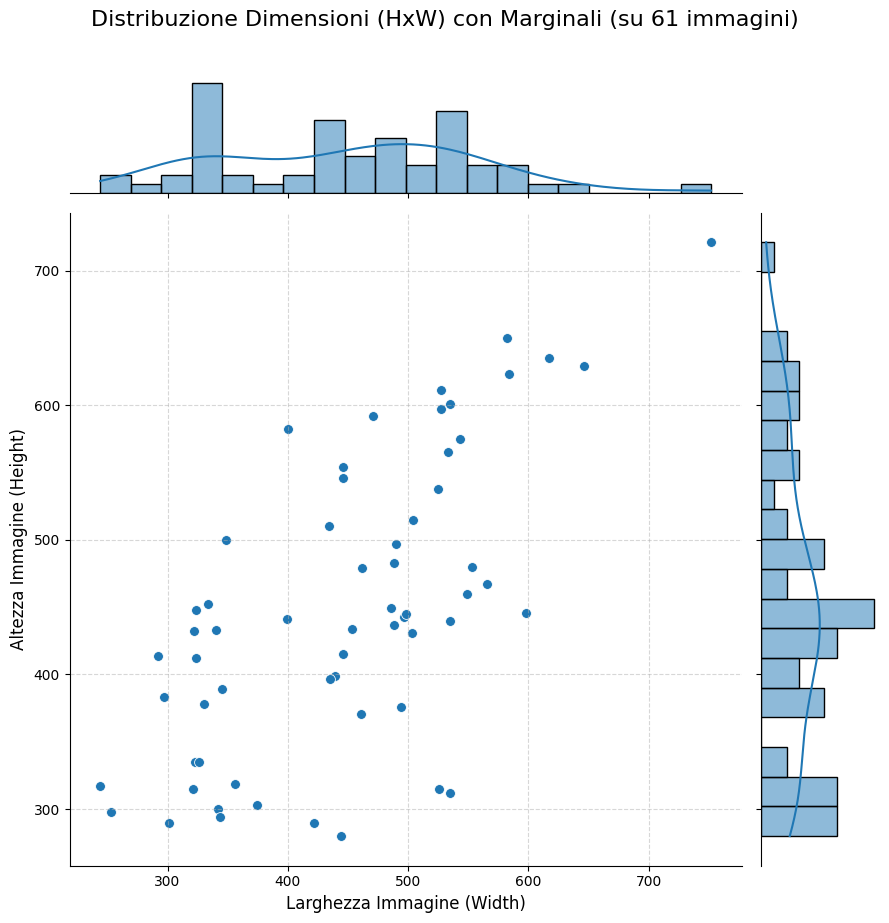

In [18]:
### Cella 4: Grafico a Dispersione con Distribuzioni Marginali (Jointplot)

import seaborn as sns

if dims_counts.empty:
    print("Nessun dato sulle dimensioni da plottare.")
else:
    print("Generazione Grafico Congiunto (Jointplot) con marginali...")
    
    # sns.jointplot è lo strumento perfetto per questo
    g = sns.jointplot(
        data=dims_counts,
        x='width',
        y='height',
        kind='scatter',  # Grafico centrale
        s=50,            # Dimensione dei punti
        height=9,        # Dimensione totale del grafico
        marginal_kws=dict(bins=20, kde=True) # Aggiunge istogramma e stima di densità
    )
    
    # Aggiungi una griglia solo al grafico centrale
    g.ax_joint.grid(True, linestyle='--', alpha=0.5)
    
    # Aggiungi un titolo (jointplot richiede suptitle)
    g.fig.suptitle(f"Distribuzione Dimensioni (HxW) con Marginali (su {len(dims_counts)} immagini)", 
                   y=1.02, fontsize=16)
    
    # Pulisce i label degli assi generati da jointplot
    g.set_axis_labels("Larghezza Immagine (Width)", "Altezza Immagine (Height)", fontsize=12)
    
    plt.tight_layout()
    plt.show()

Avvio Task 3: Calcolo della distribuzione globale delle label...

--- Distribuzione Globale dei Voxel (su 61 immagini e 12,709,334 Voxel totali) ---
 ID Label             Classe  Conteggio Voxel  Percentuale (%)
        0          Unlabeled         11805660            92.89
        4    BG (Background)           445540             3.51
        1 NT (Normal Tissue)           308328             2.43
        3  BV (Blood Vessel)           112407             0.88
        2  TT (Tumor Tissue)            37399             0.29

Generazione Grafico a Barre della Distribuzione...


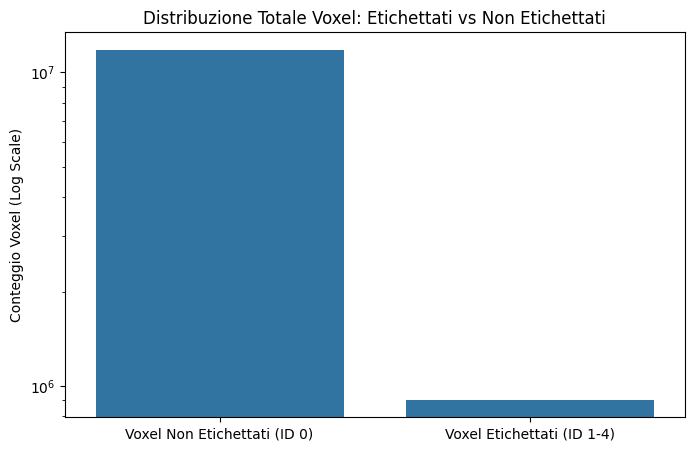

/tmp/ipykernel_89967/2419384534.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


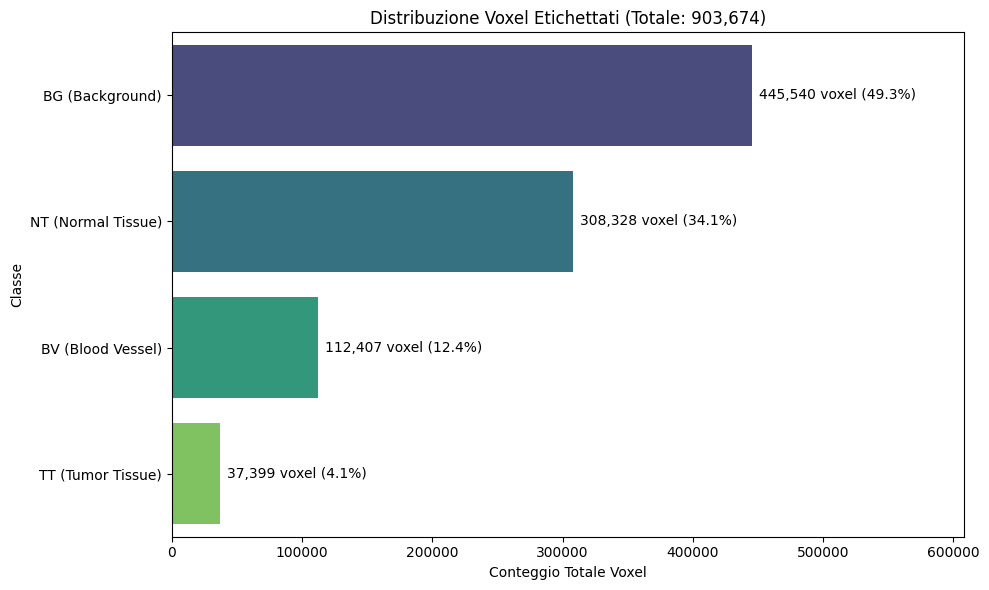

In [ ]:
### Cella 4: Task 3 - Distribuzione Globale delle Classi (da gtMap)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Avvio Task 3: Calcolo della distribuzione globale delle label...")

# Mappatura basata sul file .hdr fornito
# Nota: L'ID 3 è 'Hypervascularized Tissue', che chiamiamo 'BV'
# come da tua richiesta e convenzione del paper.
label_map = {
    0: "Unlabeled",
    1: "NT (Normal Tissue)",
    2: "TT (Tumor Tissue)",
    3: "BV (Blood Vessel)",
    4: "BG (Background)"
}

# Inizializza i conteggi totali
# Usiamo un dizionario per flessibilità
total_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Lista per i conteggi per-immagine
per_image_counts = []

for instance_id, paths in data_catalog.items():
    try:
        # Carica la mappa di ground truth processata
        gt_map = np.load(paths['processed_gt_npy']) #
        
        # Calcola i conteggi unici per questa immagine
        # bincount è molto più veloce di np.unique per interi densi
        counts = np.bincount(gt_map.ravel(), minlength=len(label_map))
        
        # Aggiorna i conteggi totali
        for i, count in enumerate(counts):
            if i in total_counts:
                total_counts[i] += count
        
        per_image_counts.append({"instance": instance_id, **dict(zip(counts, label_map))})

    except FileNotFoundError:
        print(f"File non trovato per {instance_id}, salto.")
    except Exception as e:
        print(f"Errore su {instance_id}: {e}")

# --- Prepara i dati per la visualizzazione ---

# Calcola il totale di tutti i Voxel
total_Voxels = sum(total_counts.values())

# Prepara la tabella dei risultati
results_data = []
for label_id, class_name in label_map.items():
    count = total_counts.get(label_id, 0)
    percentage = (count / total_Voxels) * 100 if total_Voxels > 0 else 0
    results_data.append({
        "ID Label": label_id,
        "Classe": class_name,
        "Conteggio Voxel": count,
        "Percentuale (%)": percentage
    })

df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values(by="Percentuale (%)", ascending=False)

print(f"\n--- Distribuzione Globale dei Voxel (su {len(per_image_counts)} immagini e {total_Voxels:,.0f} Voxel totali) ---")
print(df_results.to_string(index=False, float_format="%.2f"))

# --- Generazione Plot ---
print("\nGenerazione Grafico a Barre della Distribuzione...")

# Separiamo Labeled vs Unlabeled per il plot
labeled_Voxels = df_results[df_results['Classe'] != 'Unlabeled']['Conteggio Voxel'].sum()
unlabeled_Voxels = df_results[df_results['Classe'] == 'Unlabeled']['Conteggio Voxel'].sum()

# Plot 1: Labeled vs Unlabeled
plt.figure(figsize=(8, 5))
sns.barplot(
    x=['Voxel Non Etichettati (ID 0)', 'Voxel Etichettati (ID 1-4)'],
    y=[unlabeled_Voxels, labeled_Voxels]
)
plt.title('Distribuzione Totale Voxel: Etichettati vs Non Etichettati')
plt.ylabel('Conteggio Voxel (Log Scale)')
plt.yscale('log') # Usa scala logaritmica data la grande differenza
plt.show()

# Plot 2: Distribuzione solo delle classi etichettate
df_plot = df_results[df_results['Classe'] != 'Unlabeled'].copy()
total_labeled = df_plot['Conteggio Voxel'].sum()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_plot,
    x="Conteggio Voxel",
    y="Classe",
    palette="viridis",
    order=df_plot.sort_values(by="Conteggio Voxel", ascending=False)['Classe']
)

ax.set_title(f"Distribuzione Voxel Etichettati (Totale: {total_labeled:,.0f})")
ax.set_xlabel("Conteggio Totale Voxel")
ax.set_ylabel("Classe")

# Aggiungi etichette con le percentuali *relative ai soli Voxel etichettati*
for p in ax.patches:
    width = p.get_width()
    perc = 100 * width / total_labeled
    ax.text(width + 5000, # Posiziona il testo dopo la barra
            p.get_y() + p.get_height() / 2,
            f'{width:,.0f} voxel ({perc:.1f}%)', 
            va='center')

# Aumenta il limite dell'asse x per fare spazio alle etichette
ax.set_xlim(right=ax.get_xlim()[1] * 1.3)

plt.tight_layout()
plt.show()

In [21]:
### Cella 5: Task 4 - Preparazione Dati (Conteggi per Immagine)

print("Avvio Task 4: Calcolo conteggi per-immagine...")

# Assicurati che 'data_catalog' esista dalla Cella 2
if 'data_catalog' not in locals():
    print("Errore: 'data_catalog' non trovato. Esegui prima la Cella 2.")
    
# Assicurati che 'label_map' esista dalla Cella 4
if 'label_map' not in locals():
    label_map = {
        0: "Unlabeled",
        1: "NT (Normal Tissue)",
        2: "TT (Tumor Tissue)",
        3: "BV (Blood Vessel)",
        4: "BG (Background)"
    }

per_image_data = []

for instance_id, paths in data_catalog.items():
    try:
        # Carica la gtMap.npy
        gt_map = np.load(paths['processed_gt_npy'])
        
        # Calcola i conteggi per 0, 1, 2, 3, 4
        counts = np.bincount(gt_map.ravel(), minlength=len(label_map))
        
        # Crea un dizionario per questa riga
        row = {"instance": instance_id}
        for label_id, class_name in label_map.items():
            if label_id < len(counts):
                row[class_name] = counts[label_id]
            else:
                row[class_name] = 0
        
        per_image_data.append(row)

    except FileNotFoundError:
        pass # Già segnalato nei task precedenti

# Converti in DataFrame
df_per_image = pd.DataFrame(per_image_data)

# Aggiungi un indice numerico semplice (0-60) per l'asse x
df_per_image['image_index'] = np.arange(len(df_per_image))

print(f"DataFrame per-immagine creato con {len(df_per_image)} righe.")
print(df_per_image.head())

Avvio Task 4: Calcolo conteggi per-immagine...
DataFrame per-immagine creato con 61 righe.
  instance  Unlabeled  NT (Normal Tissue)  TT (Tumor Tissue)  \
0   004-02     126241                5007                  0   
1   005-01     207433                6061                  0   
2   007-01     223997                7714                  0   
3   008-01     247063                2295               1221   
4   008-02     254671                2187                138   

   BV (Blood Vessel)  BG (Background)  image_index  
0                965             1992            0  
1               1727            20483            1  
2               1089                0            2  
3               1331              630            3  
4               1000             7444            4  



Generazione Grafico a Linee (Conteggi per Immagine)...


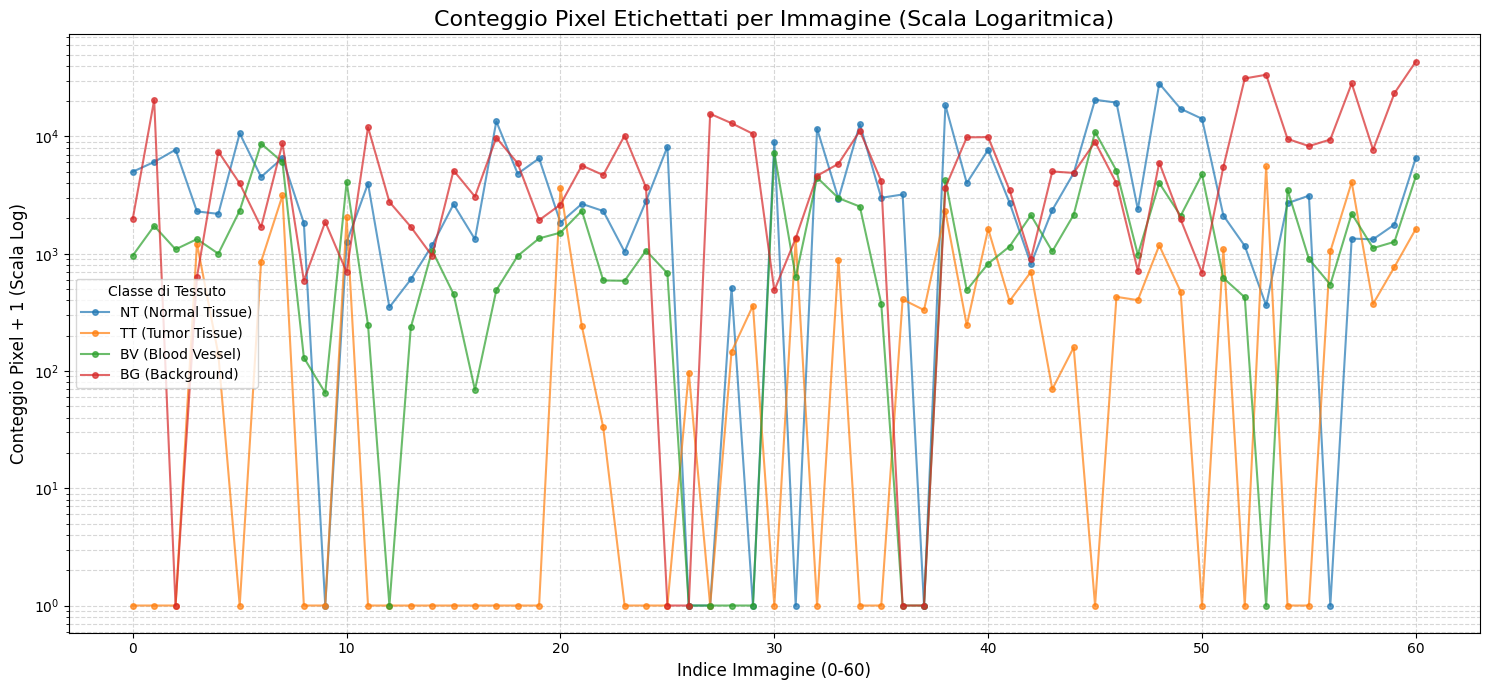

In [25]:
### Cella 6: Task 4 - Plot a Linee dei Conteggi per Immagine

print("\nGenerazione Grafico a Linee (Conteggi per Immagine)...")

# Seleziona le colonne da plottare (come richiesto, escludi 'Unlabeled')
columns_to_plot = [
    "NT (Normal Tissue)",
    "TT (Tumor Tissue)",
    "BV (Blood Vessel)",
    "BG (Background)"
]

if not df_per_image.empty:
    plt.figure(figsize=(15, 7))
    
    # Crea un lineplot per ogni classe
    for col in columns_to_plot:
        # Aggiungiamo 1 (smoothing) prima di plottare in scala logaritmica
        # Questo evita problemi con conteggi pari a 0 (log(0) è -infinito)
        plt.plot(df_per_image['image_index'], df_per_image[col] + 1, 
                 label=col, marker='o', markersize=4, alpha=0.7)
    
    # È FONDAMENTALE usare una scala logaritmica per l'asse Y
    # Altrimenti, BG (Background) schiaccerà tutte le altre linee a zero
    plt.yscale('log')
    
    plt.title('Conteggio Pixel Etichettati per Immagine (Scala Logaritmica)', fontsize=16)
    plt.xlabel('Indice Immagine (0-60)', fontsize=12)
    plt.ylabel('Conteggio Pixel + 1 (Scala Log)', fontsize=12)
    
    # Come richiesto, l'asse x mostrerà solo alcuni indici (es. 0, 10, 20...)
    # lasciando che matplotlib scelga automaticamente i tick
    
    plt.legend(title="Classe di Tessuto")
    plt.grid(True, linestyle='--', which='both', alpha=0.5) # Griglia per log scale
    plt.tight_layout()
    plt.show()
    
else:
    print("DataFrame 'df_per_image' è vuoto. Esegui la cella precedente.")

In [26]:
### Cella 7: Task 5 - Conteggio Immagini senza pixel TT (Tumor Tissue)

print("Avvio Task 5: Conteggio delle immagini senza pixel TT (ID=2)...")

# Lista per salvare i nomi delle immagini che soddisfano la condizione
images_with_no_tt = []
file_not_found_count = 0
total_images_checked = 0

# ID per 'Tumor Tissue' come da gtMap.hdr e train.py
TT_LABEL_ID = 2 

for instance_id, paths in data_catalog.items():
    try:
        # Carica la mappa di ground truth
        gt_map = np.load(paths['processed_gt_npy']) #
        total_images_checked += 1
        
        # Controlla se NESSUN pixel ha il valore 2 (TT)
        # np.any() è molto efficiente per questo
        if not np.any(gt_map == TT_LABEL_ID):
            images_with_no_tt.append(instance_id)
            
    except FileNotFoundError:
        print(f"File non trovato per {instance_id}, salto.")
        file_not_found_count += 1
    except Exception as e:
        print(f"Errore su {instance_id}: {e}")

# --- Stampa i Risultati ---
print("\n--- Risultati del Conteggio ---")
print(f"Immagini totali controllate: {total_images_checked}")
print(f"Immagini con file .npy mancanti: {file_not_found_count}")

print(f"\nNumero di immagini con 0 pixel mappati a TT (ID=2): {len(images_with_no_tt)}")

if len(images_with_no_tt) > 0:
    print("\nLista delle immagini senza pixel TT:")
    # Stampa in un formato pulito, 5 per riga
    for i, instance_id in enumerate(images_with_no_tt):
        print(f"  {instance_id: <10}", end="")
        if (i + 1) % 5 == 0:
            print() # Vai a capo ogni 5
    print() # Linea finale

Avvio Task 5: Conteggio delle immagini senza pixel TT (ID=2)...

--- Risultati del Conteggio ---
Immagini totali controllate: 61
Immagini con file .npy mancanti: 0

Numero di immagini con 0 pixel mappati a TT (ID=2): 28

Lista delle immagini senza pixel TT:
  004-02      005-01      007-01      010-03      013-01    
  014-01      016-01      016-02      016-03      016-04    
  016-05      017-01      018-01      018-02      019-01    
  021-05      022-01      022-02      034-01      035-01    
  036-01      037-01      037-02      042-01      043-04    
  051-01      054-01      055-01    


Avvio Task 6: Plot delle distribuzioni spettrali (Mediana/Quartili)...
Inizio campionamento (max 30000 pixel/classe/immagine)...
Campionamento completato.
Calcolo statistiche e generazione grafici...


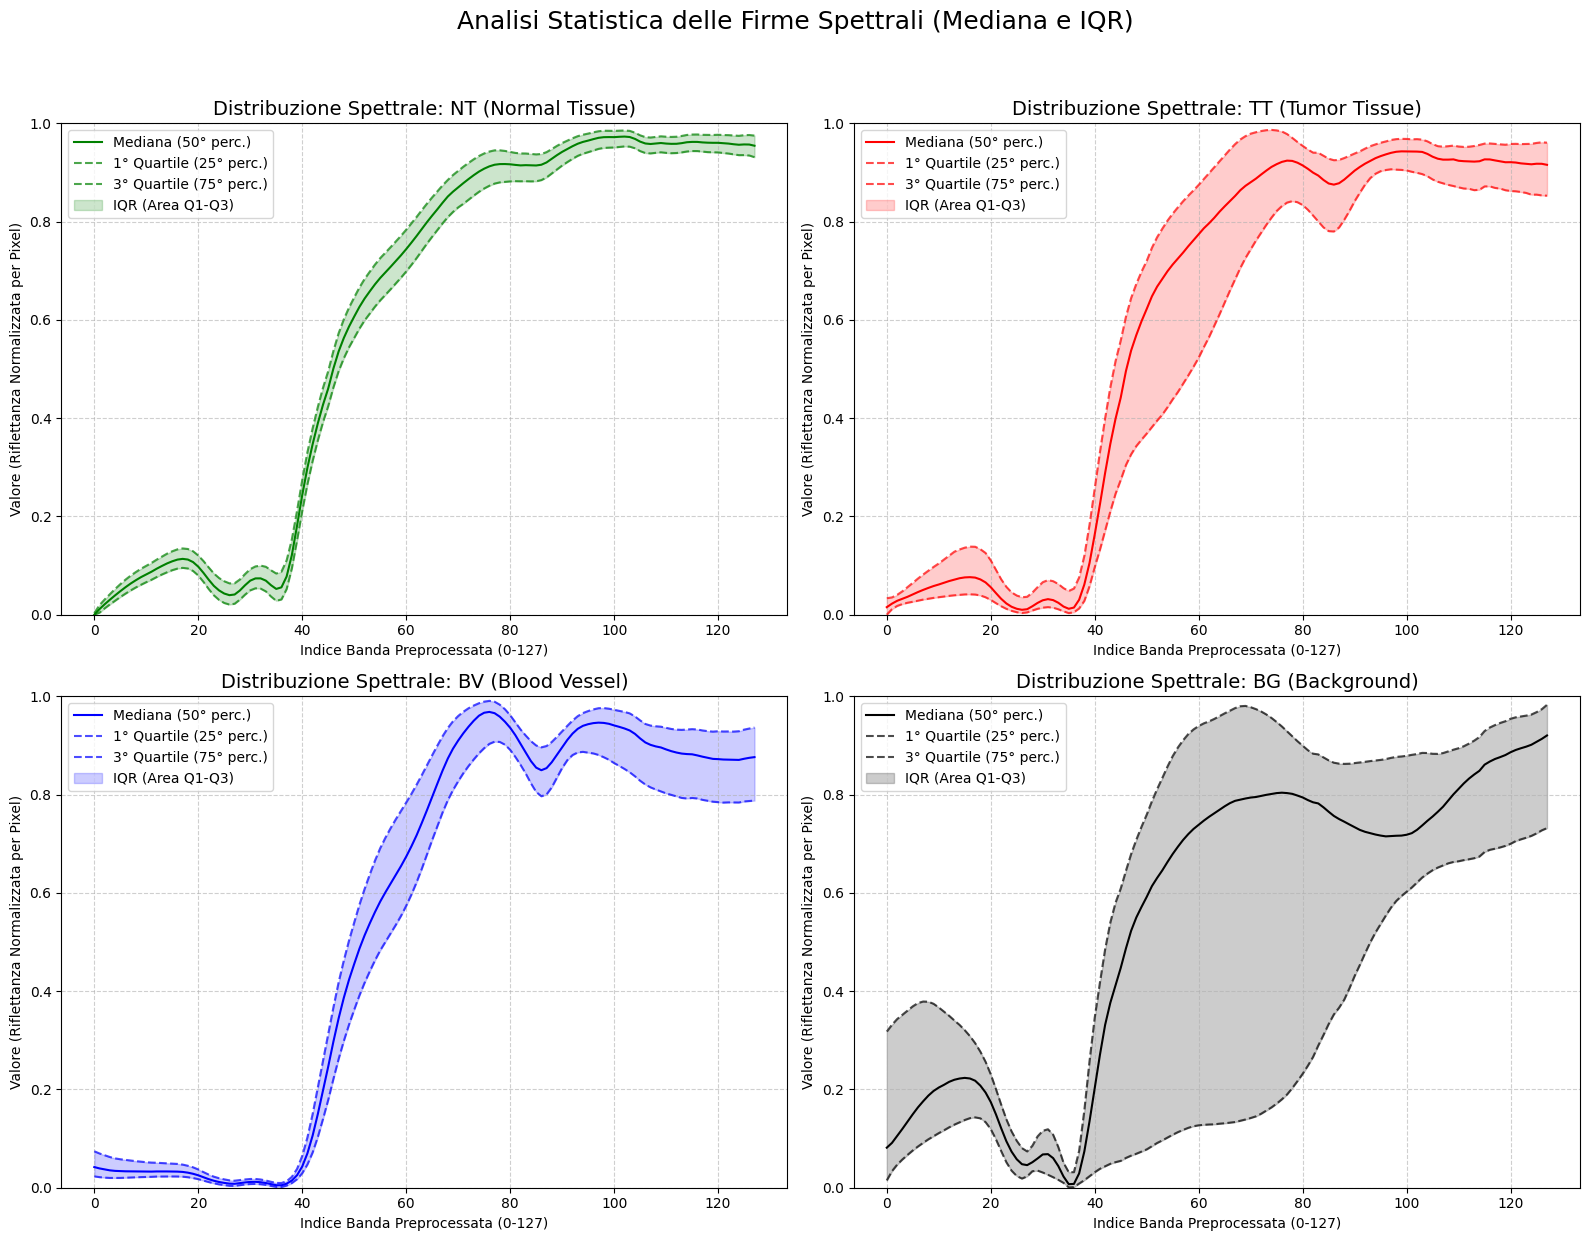

In [28]:
### Cella 8: Task 6 - Plot delle Firme Spettrali (Mediana e Quartili)

print("Avvio Task 6: Plot delle distribuzioni spettrali (Mediana/Quartili)...")

# --- 1. Campionamento dei Dati ---
# Non possiamo caricare tutti i pixel di tutte le 61 immagini in memoria.
# Creiamo un campione rappresentativo prendendo un massimo di pixel
# per ogni classe da ogni immagine.

MAX_PIXELS_PER_CLASS_PER_IMAGE = 30000 # Puoi abbassare a 500 se è troppo lento
rng = np.random.default_rng(42) # Per la riproducibilità del campionamento

# Mappa senza "Unlabeled"
label_map_plot = {
    1: "NT (Normal Tissue)",
    2: "TT (Tumor Tissue)",
    3: "BV (Blood Vessel)",
    4: "BG (Background)"
}

# Dizionario per accumulare gli spettri campionati
class_spectra = {name: [] for name in label_map_plot.values()}

print(f"Inizio campionamento (max {MAX_PIXELS_PER_CLASS_PER_IMAGE} pixel/classe/immagine)...")

for instance_id, paths in data_catalog.items():
    try:
        gt_map = np.load(paths['processed_gt_npy'])
        cube = np.load(paths['processed_cube_npy']) # Shape (128, H, W)
        
        # Reshape per un accesso più facile ai pixel
        # (Bande, H, W) -> (H, W, Bande) -> (Pixel, Bande)
        bands, H, W = cube.shape
        cube_flat = cube.reshape(bands, -1).T # Shape (H*W, 128)
        gt_flat = gt_map.ravel()

        for label_id, class_name in label_map_plot.items():
            # Trova gli indici di tutti i pixel per questa classe
            pixel_indices = np.where(gt_flat == label_id)[0]
            count = len(pixel_indices)
            
            if count > 0:
                # Se abbiamo più pixel del nostro limite, campioniamo
                if count > MAX_PIXELS_PER_CLASS_PER_IMAGE:
                    sampled_indices = rng.choice(pixel_indices, 
                                                 MAX_PIXELS_PER_CLASS_PER_IMAGE, 
                                                 replace=False)
                else:
                    # Altrimenti, li prendiamo tutti
                    sampled_indices = pixel_indices
                
                # Aggiungi i dati spettrali (N, 128) alla nostra lista
                class_spectra[class_name].append(cube_flat[sampled_indices, :])

    except FileNotFoundError:
        continue # Salta le immagini non trovate
    except Exception as e:
        print(f"Errore su {instance_id}: {e}")

print("Campionamento completato.")

# --- 2. Calcolo Statistiche e Plot ---

# Definiamo l'asse X, che è lo stesso per tutti
# I nostri cubi processati hanno 128 bande
band_indices = np.arange(128) 

# Creiamo una griglia 2x2 per i 4 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Appiattiamo 'axes' per iterare facilmente
axes_flat = axes.ravel()
color_map = {'NT (Normal Tissue)': 'g', 'TT (Tumor Tissue)': 'r', 'BV (Blood Vessel)': 'b', 'BG (Background)': 'k'}

print("Calcolo statistiche e generazione grafici...")

for i, (class_name, color) in enumerate(color_map.items()):
    ax = axes_flat[i]
    
    if not class_spectra[class_name]:
        print(f"Nessun pixel trovato per la classe: {class_name}")
        ax.set_title(f"{class_name}\n(Nessun dato)")
        continue
        
    # Combina tutti gli array di pixel campionati in un unico grande array
    all_pixels_for_class = np.vstack(class_spectra[class_name])
    
    if all_pixels_for_class.shape[0] == 0:
        print(f"Nessun pixel trovato per la classe: {class_name}")
        ax.set_title(f"{class_name}\n(Nessun dato)")
        continue
    
    # Calcola i quartili [25, 50, 75] lungo l'asse dei pixel (axis=0)
    # q[0] = Q1 (25° percentile)
    # q[1] = Mediana (50° percentile)
    # q[2] = Q3 (75° percentile)
    q = np.percentile(all_pixels_for_class, [25, 50, 75], axis=0)
    
    median_line = q[1]
    q1_line = q[0]
    q3_line = q[2]
    
    # Plotta la Mediana (la tua "retta" centrale)
    ax.plot(band_indices, median_line, label="Mediana (50° perc.)", 
            color=color, linestyle='-')
    
    # Plotta Q1 e Q3 (le tue 2 "rette" esterne)
    ax.plot(band_indices, q1_line, label="1° Quartile (25° perc.)", 
            color=color, linestyle='--', alpha=0.7)
    ax.plot(band_indices, q3_line, label="3° Quartile (75° perc.)", 
            color=color, linestyle='--', alpha=0.7)
    
    # Ombreggia l'area tra Q1 e Q3 (Interquartile Range)
    ax.fill_between(band_indices, q1_line, q3_line, 
                    color=color, alpha=0.2, label="IQR (Area Q1-Q3)")
    
    ax.set_title(f"Distribuzione Spettrale: {class_name}", fontsize=14)
    ax.set_xlabel("Indice Banda Preprocessata (0-127)")
    ax.set_ylabel("Valore (Riflettanza Normalizzata per Pixel)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(0, 1) # I dati sono normalizzati [0, 1]

plt.suptitle("Analisi Statistica delle Firme Spettrali (Mediana e IQR)", 
             fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

I plot visti sopra vanno bene, tuttavia bisogna ricosturire le frequenze a cui corrispondono le bande. 

UNa cosa interessante, è che la TT ha un'oscillazione maggiore  del BV prima di 40.  Inoltre ha un andamento simile al BV, ma diverso del NT, tra 70 e 90. 

#Aggiungere gli stessi plot con le immagini non processate

Avvio Task 7: Analisi Informatività delle Bande...
Dati di analisi pronti: X shape (885256, 128), y shape (885256,)
Calcolo Task 1: Varianza per banda...
Calcolo Task 2: Correlazione bande adiacenti...
Calcolo Task 3: Punteggi ANOVA F-test per classe...
Generazione grafici...


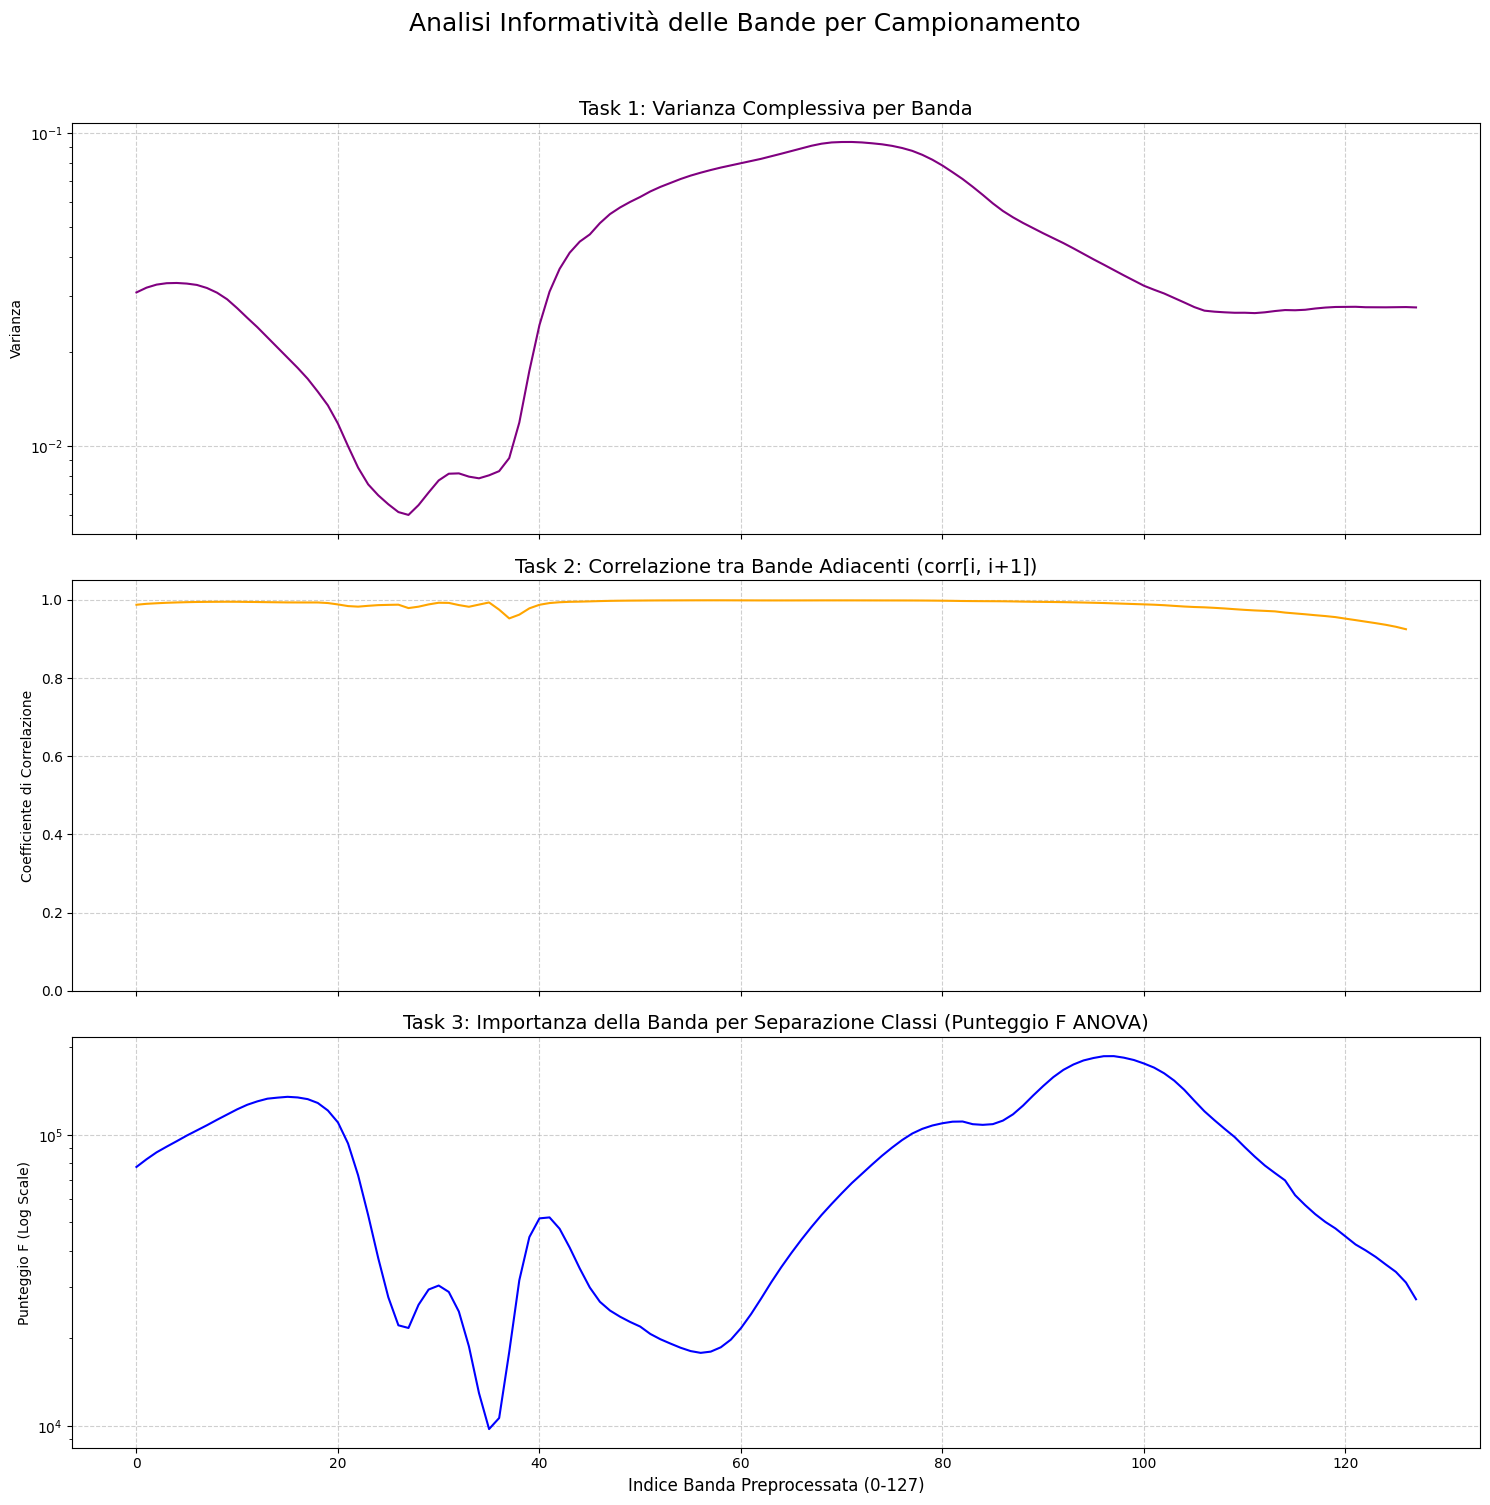

In [29]:
### Cella 9: Task 7 - Analisi Informatività delle Bande (Varianza, Correlazione, ANOVA)

from sklearn.feature_selection import f_classif

print("Avvio Task 7: Analisi Informatività delle Bande...")

# --- 1. Preparazione Dati ---
# Assicurati che 'class_spectra' e 'label_map_plot' esistano dalle celle precedenti

# Combiniamo tutti i campioni etichettati in un unico array X e y
X_list = []
y_list = []

# Mappiamo i nomi delle classi (stringhe) ai loro ID (interi)
# NOTA: Usiamo gli ID originali (1, 2, 3, 4) perché ANOVA li gestisce
for label_id, class_name in label_map_plot.items():
    if class_spectra[class_name]:
        # Estrai tutti i campioni per questa classe
        class_pixels_for_class = np.vstack(class_spectra[class_name])
        X_list.append(class_pixels_for_class)
        # Crea le etichette corrispondenti
        y_list.append(np.full(len(class_pixels_for_class), label_id))

# Array finali per l'analisi
X_all_labeled = np.vstack(X_list)
y_all_labeled = np.concatenate(y_list)

print(f"Dati di analisi pronti: X shape {X_all_labeled.shape}, y shape {y_all_labeled.shape}")

# Definisci l'asse X
band_indices = np.arange(X_all_labeled.shape[1]) # 0-127

# --- 2. Calcolo delle Metriche ---

# Task 1: Varianza Complessiva
print("Calcolo Task 1: Varianza per banda...")
variances = np.var(X_all_labeled, axis=0)

# Task 2: Correlazione Adiacente
print("Calcolo Task 2: Correlazione bande adiacenti...")
# Creare un DataFrame è il modo più semplice per .corr()
df_bands = pd.DataFrame(X_all_labeled)
# Calcola la matrice di correlazione 128x128
corr_matrix = df_bands.corr()
# Estrai solo la prima diagonale (correlazione tra banda 'i' e 'i+1')
adj_corr = np.diag(corr_matrix, k=1)

# Task 3: Punteggi ANOVA F-test
print("Calcolo Task 3: Punteggi ANOVA F-test per classe...")
# f_classif calcola il punteggio F di ANOVA per ogni feature (banda)
# Questo misura quanto bene la banda separa le classi in y
f_scores, p_values = f_classif(X_all_labeled, y_all_labeled)


# --- 3. Plotting ---
print("Generazione grafici...")
fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# Grafico 1: Varianza
ax = axes[0]
ax.plot(band_indices, variances, color='purple')
ax.set_title("Task 1: Varianza Complessiva per Banda", fontsize=14)
ax.set_ylabel("Varianza")
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_yscale('log') # La varianza può variare molto

# Grafico 2: Correlazione Adiacente
ax = axes[1]
# Nota: adj_corr ha 127 elementi (da 0-1 a 126-127)
ax.plot(band_indices[:-1], adj_corr, color='orange')
ax.set_title("Task 2: Correlazione tra Bande Adiacenti (corr[i, i+1])", fontsize=14)
ax.set_ylabel("Coefficiente di Correlazione")
ax.set_ylim(0, 1.05) # La correlazione è [0, 1]
ax.grid(True, linestyle='--', alpha=0.6)

# Grafico 3: Punteggi ANOVA
ax = axes[2]
ax.plot(band_indices, f_scores, color='blue')
ax.set_title("Task 3: Importanza della Banda per Separazione Classi (Punteggio F ANOVA)", fontsize=14)
ax.set_ylabel("Punteggio F (Log Scale)")
ax.set_xlabel("Indice Banda Preprocessata (0-127)", fontsize=12)
ax.set_yscale('log') # I punteggi F possono variare molto
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Aggiusta per il suptitle
fig.suptitle("Analisi Informatività delle Bande per Campionamento", fontsize=18, y=1.03)
plt.show()

### 📈 Task 1: Varianza Complessiva per Banda

Cosa: Plottiamo la varianza totale di ogni singola banda (da 0 a 127) su tutti i pixel campionati. Perché: Questo ti mostra quali bande sono "rumorose" o "piatte". Le bande con varianza quasi nulla sono inutili (non aiutano a distinguere nulla) e possono essere scartate. Le bande con varianza molto alta potrebbero essere informative, o semplicemente rumorose.

### 🔗 Task 2: Correlazione Locale (Bande Adiacenti)

Cosa: Plottiamo la correlazione di ogni banda solo con la banda immediatamente successiva (es. banda 0 con 1, 1 con 2, ... 126 con 127). Perché: Questo identifica i "range" di bande altamente ridondanti. Se vedi un plateau nel grafico dove la correlazione è 0.99 per 10 bande di fila, sai che quelle 10 bande contengono la stessa informazione e puoi campionarne solo una da quel blocco.

### 🔥 Task 3: Potere di Separazione delle Classi (ANOVA F-test)

Cosa: Calcoliamo un "punteggio di importanza" (feature importance) per ogni banda. Usiamo il test F di ANOVA, che è un metodo statistico veloce. Perché: Questo è il grafico più importante per te. Non misura solo la varianza, ma misura quanto la varianza di una banda sia spiegata dalla divisione in classi.

- Un punteggio F alto significa che i valori di quella banda sono molto diversi tra le classi (es. NT ha valori bassi, TT ha valori alti). Queste sono le bande che devi campionare!
- Un punteggio F basso significa che quella banda è inutile per la classificazione.

Questa è un'analisi eccellente. Questi tre grafici, letti insieme, ti dicono esattamente dove si trova l'informazione utile nei tuoi dati e ti forniscono una chiara strategia di campionamento.

Ecco l'interpretazione:

Analisi dei Grafici

    Task 2 (Correlazione, Arancione): Come sospettavi, questo grafico mostra che la correlazione tra bande adiacenti è quasi sempre sopra il 95%. Questo significa che la maggior parte delle bande sono altamente ridondanti. Prendere le bande 5, 6, 7, 8, 9 è quasi inutile; ti basterebbe la 5 e la 9. Il tuo script preprocess.py attuale, che campiona uniformemente 128 bande, sta conservando molta di questa ridondanza.

    Task 3 (Importanza ANOVA, Blu): Questo è il grafico più importante. Mostra quali bande sono veramente utili per distinguere le classi (NT, TT, BV, BG). I picchi indicano le bande migliori per la classificazione:

        Range 1 (Alto): Bande ~0-20.

        Range 2 (Medio): Un picco stretto e molto netto intorno alla banda ~38.

        Range 3 (Altissimo): L'importanza esplode dalla banda ~70, raggiungendo il picco massimo assoluto intorno alla banda ~95-100.

    Task 1 (Varianza, Viola): Questo grafico conferma la storia. Nota come le bande con l'importanza (punteggio F) più bassa in assoluto (range ~40-60) siano anche quelle con la varianza più bassa. Questo ha senso: se una banda ha quasi sempre lo stesso valore per tutti i pixel, non può essere usata per distinguere nulla.

Conclusione e Strategia di Campionamento

Sì, puoi campionare in modo non uniforme, ed è esattamente ciò che dovresti fare.

I tuoi dati mostrano che l'informazione non è distribuita equamente. Invece di prendere 128 bande uniformi, potresti ottenere performance uguali (o migliori) con molte meno bande, campionando in modo mirato:

    Range da Campionare Densamente (Es. ogni 2-3 bande):

        0-20

        35-40

        70-120

    Range da Campionare Sparsamente (Es. ogni 10-15 bande):

        20-35

        60-70

        120-127

    Range da Ignorare (Quasi inutili):

        40-60

Rilevata esecuzione da 'scripts/'. BASE_DIR impostato a: /home/ale/repos/HSI-benchmark-eval
Avvio Analisi Errori. Cartella CSV: /home/ale/repos/HSI-benchmark-eval/outputs/analysis_results
[INFO] Trovata run per 'random': random_20251115_183848
[random] Generazione grafici firme spettrali...


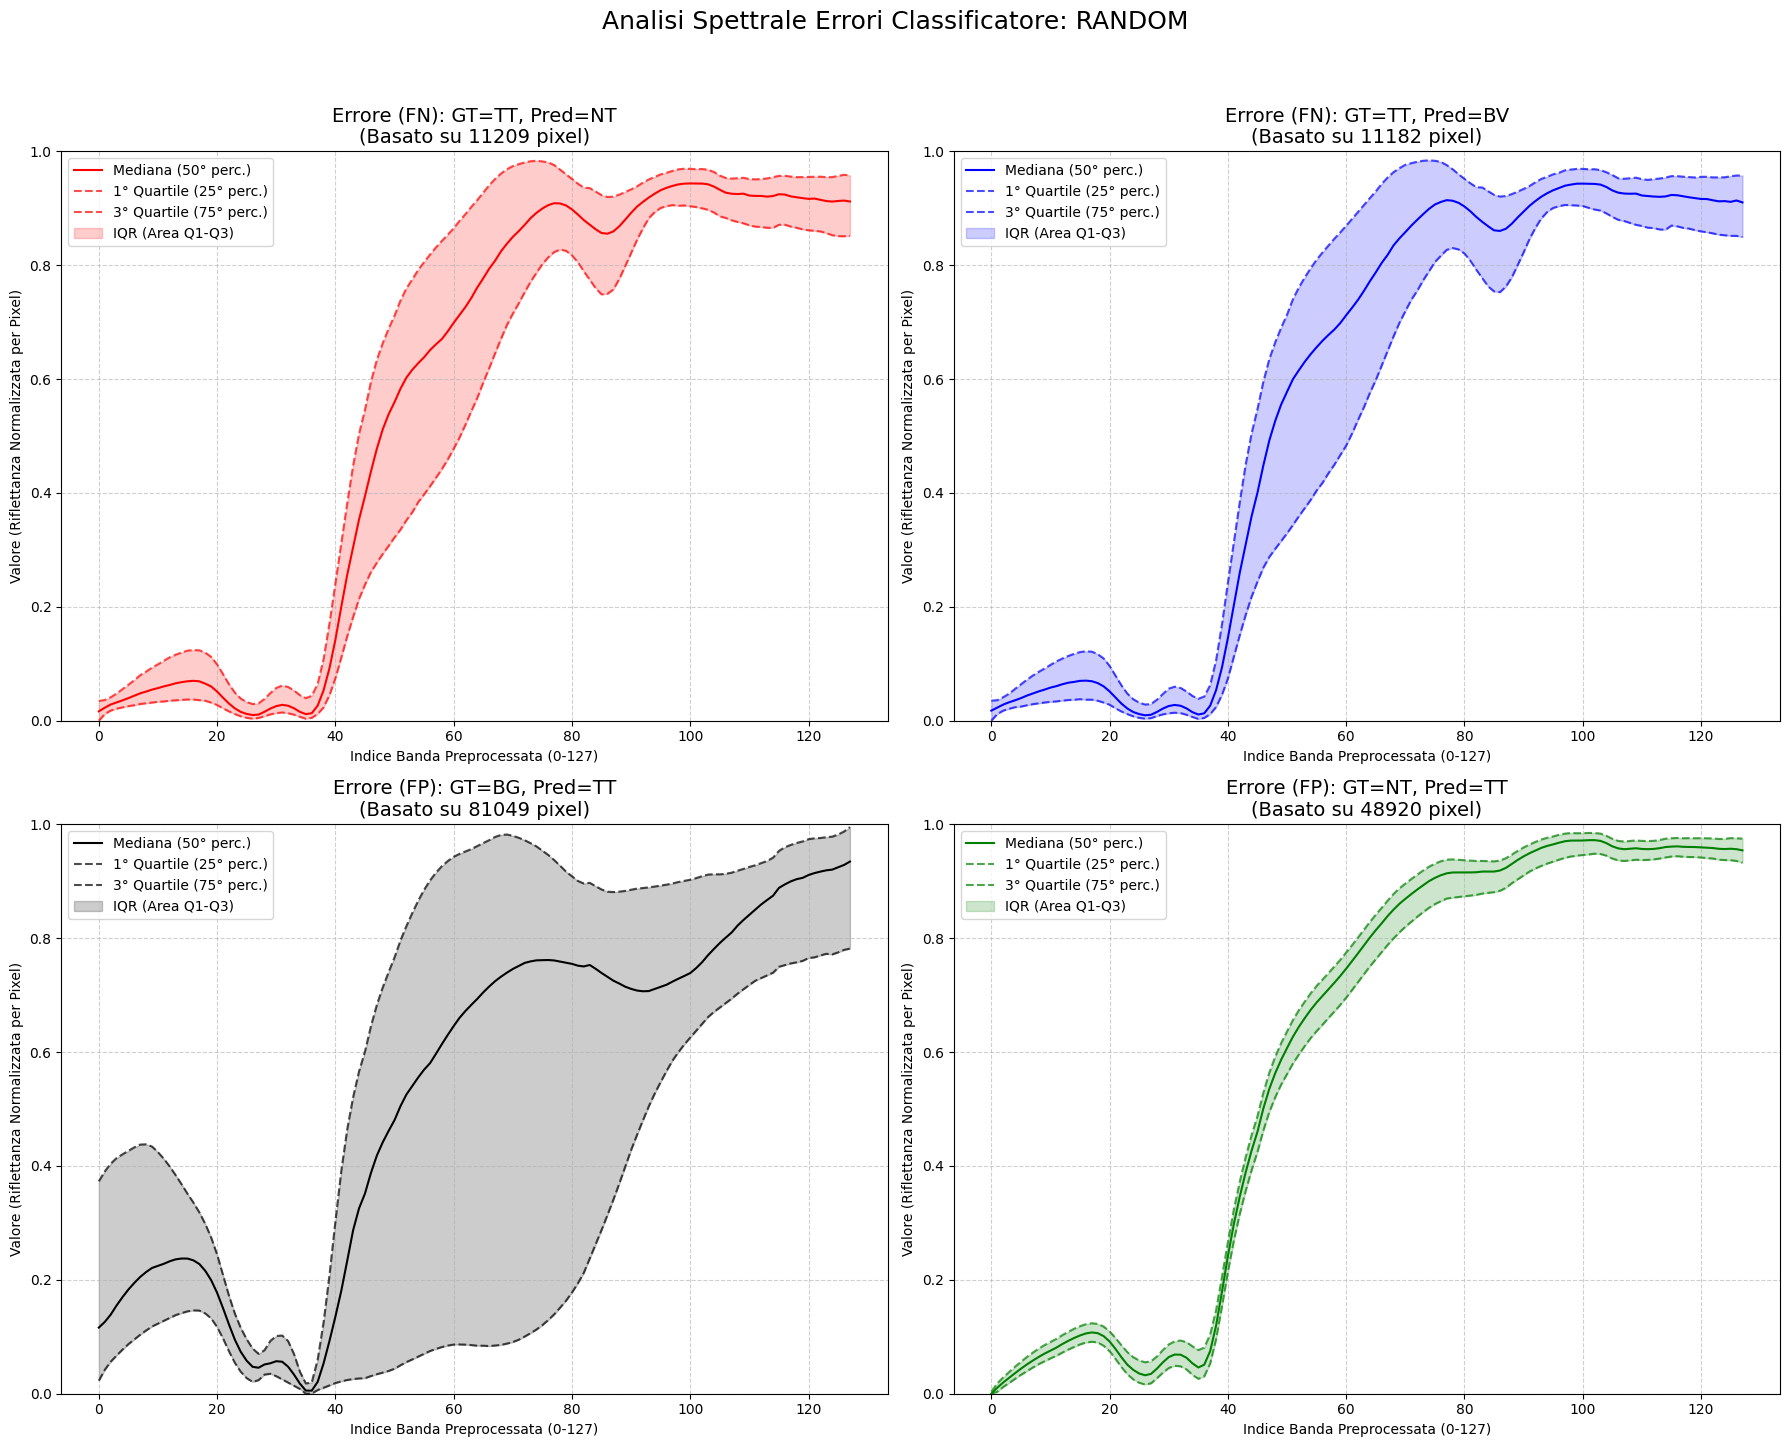

[random] ✅ Grafico mostrato inline.
[INFO] Trovata run per 'svm-l': svm-l_20251112_024337
[svm-l] NESSUNA cartella 'fold_X_predictions' trovata in /home/ale/repos/HSI-benchmark-eval/outputs/svm-l_20251112_024337.
[INFO] Trovata run per 'svm-rbf': svm-rbf_20251112_041304
[svm-rbf] NESSUNA cartella 'fold_X_predictions' trovata in /home/ale/repos/HSI-benchmark-eval/outputs/svm-rbf_20251112_041304.
[INFO] Trovata run per 'knn-e': knn-e_20251112_144001
[knn-e] NESSUNA cartella 'fold_X_predictions' trovata in /home/ale/repos/HSI-benchmark-eval/outputs/knn-e_20251112_144001.
[INFO] Trovata run per 'knn-c': knn-c_20251112_152155
[knn-c] NESSUNA cartella 'fold_X_predictions' trovata in /home/ale/repos/HSI-benchmark-eval/outputs/knn-c_20251112_152155.
[INFO] Trovata run per 'rf': rf_20251112_162132
[rf] NESSUNA cartella 'fold_X_predictions' trovata in /home/ale/repos/HSI-benchmark-eval/outputs/rf_20251112_162132.
[INFO] Trovata run per 'dnn': dnn_20251111_221604
[dnn] NESSUNA cartella 'fold_X_pr


--- Analisi Completata ---
Riepilogo metriche salvato in: /home/ale/repos/HSI-benchmark-eval/outputs/analysis_results/report_metriche_binarie.csv


In [6]:
# Magic command per mostrare i grafici direttamente nel notebook
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import warnings

# Ignora avvisi comuni (es. divisione per zero in metriche, percentile su array vuoti)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. CONFIGURAZIONE ---

# Dizionario per selezionare quali modelli analizzare
# Lo script cercherà l'ULTIMA run in 'outputs/' che inizia con questo nome
MODELS_TO_ANALYZE = {
    "random": True,
    "svm-l": True,
    "svm-rbf": True,
    "knn-e": True,
    "knn-c": True,
    "rf": True,
    "dnn": True,
    "ebeae": False, # EBEAE/NEBEAE non sono inclusi nei plot di default
    "nebeae": False,
}

# Definizioni delle classi (0-indexed)
NT, TT, BV, BG = 0, 1, 2, 3
CLASS_NAMES = {
    NT: "NT (Normal)",
    TT: "TT (Tumor)",
    BV: "BV (Vessel)",
    BG: "BG (Background)"
}

# Definizioni dei path
# --- MODIFICA CHIAVE ---
# L'errore mostra che Path.cwd() è /home/ale/repos/HSI-benchmark-eval/scripts/
# Dobbiamo salire di un livello per trovare la root del progetto.
CURRENT_DIR = Path.cwd()
if CURRENT_DIR.name == "scripts":
    BASE_DIR = CURRENT_DIR.parent
    print(f"Rilevata esecuzione da 'scripts/'. BASE_DIR impostato a: {BASE_DIR}")
else:
    BASE_DIR = CURRENT_DIR
    print(f"BASE_DIR impostato a: {BASE_DIR}")

OUTPUTS_DIR = BASE_DIR / "outputs"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
# La cartella di output serve ancora per i file CSV
ANALYSIS_OUTPUT_DIR = OUTPUTS_DIR / "analysis_results"
# Aggiunto 'parents=True' per creare ricorsivamente i path
ANALYSIS_OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
# --- FINE MODIFICA ---


# --- 2. FUNZIONI DI ANALISI ---

def find_latest_model_run(model_name: str) -> Path | None:
    """Trova la cartella della run più recente per un dato modello."""
    try:
        latest_run = sorted(list(OUTPUTS_DIR.glob(f"{model_name}_*")))[-1]
        if latest_run.is_dir():
            print(f"[INFO] Trovata run per '{model_name}': {latest_run.name}")
            return latest_run
    except IndexError:
        print(f"[WARN] Nessuna run trovata per '{model_name}'. Salto.")
    return None

def calculate_binary_metrics(y_true, y_pred, class_a, class_b):
    """
    Calcola metriche binarie (Acc, Sens, Spec, F1) solo tra due classi.
    'class_a' è trattata come POSITIVA (es. TT)
    'class_b' è trattata come NEGATIVA (es. NT)
    """
    # Filtra solo i pixel che sono o A o B nel Ground Truth
    mask = (y_true == class_a) | (y_true == class_b)
    if not np.any(mask):
        return {"accuracy": np.nan, "sensitivity": np.nan, "specificity": np.nan, "f1_score": np.nan}

    gt_binary = y_true[mask]
    pred_binary = y_pred[mask]
    
    # Converti in 0 (neg) e 1 (pos). class_a (TT) è 1.
    gt_binary = (gt_binary == class_a).astype(int)
    
    # Se la predizione non è né A né B, è comunque un errore.
    # Se pred è A (TT) -> 1. Se pred è B (NT) o C (BV) -> 0.
    pred_binary = (pred_binary == class_a).astype(int)
    
    try:
        tn, fp, fn, tp = confusion_matrix(gt_binary, pred_binary, labels=[0, 1]).ravel()
    except ValueError: # Può accadere se una classe non è mai predetta
        return {"accuracy": 0.0, "sensitivity": 0.0, "specificity": 0.0, "f1_score": 0.0}

    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    sensitivity = tp / (tp + fn + 1e-8) # Recall di class_a (TT)
    specificity = tn / (tn + fp + 1e-8) # Recall di class_b (NT/BV/BG)
    f1 = f1_score(gt_binary, pred_binary, pos_label=1, average='binary', zero_division=0.0)
    
    return {"accuracy": accuracy, "sensitivity": sensitivity, "specificity": specificity, "f1_score": f1}

def collect_misclassified_spectra(cube_flat, gt_0idx, pred_flat, all_spectra):
    """Estrae gli spettri per specifiche misclassificazioni."""
    
    # TT (verità) -> NT (predetto)
    mask_tt_as_nt = (gt_0idx == TT) & (pred_flat == NT)
    if np.any(mask_tt_as_nt):
        all_spectra["TT_as_NT"].append(cube_flat[mask_tt_as_nt])
        
    # TT (verità) -> BV (predetto)
    mask_tt_as_bv = (gt_0idx == TT) & (pred_flat == BV)
    if np.any(mask_tt_as_bv):
        all_spectra["TT_as_BV"].append(cube_flat[mask_tt_as_bv])

    # BG (verità) -> TT (predetto)
    mask_bg_as_tt = (gt_0idx == BG) & (pred_flat == TT)
    if np.any(mask_bg_as_tt):
        all_spectra["BG_as_TT"].append(cube_flat[mask_bg_as_tt])
        
    # (Puoi aggiungere altre combinazioni qui, es. NT -> TT)
    mask_nt_as_tt = (gt_0idx == NT) & (pred_flat == TT)
    if np.any(mask_nt_as_tt):
        all_spectra["NT_as_TT"].append(cube_flat[mask_nt_as_tt])

def plot_spectral_signatures(all_spectra, model_name):
    """
    Plotta la mediana e l'IQR per le firme spettrali raccolte.
    """
    print(f"[{model_name}] Generazione grafici firme spettrali...")
    
    plot_map = {
        "TT_as_NT": ("Errore (FN): GT=TT, Pred=NT", "r"),
        "TT_as_BV": ("Errore (FN): GT=TT, Pred=BV", "b"),
        "BG_as_TT": ("Errore (FP): GT=BG, Pred=TT", "k"),
        "NT_as_TT": ("Errore (FP): GT=NT, Pred=TT", "g"),
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes_flat = axes.ravel()
    band_indices = np.arange(128) # Assumendo 128 bande processate

    for i, (key, (title, color)) in enumerate(plot_map.items()):
        ax = axes_flat[i]
        
        if not all_spectra[key]:
            print(f"[{model_name}] Nessun dato per il plot: {key}")
            ax.set_title(f"{title}\n(Nessun dato)")
            continue
            
        # Combina tutti gli array di pixel campionati
        all_pixels = np.vstack(all_spectra[key])
        n_pixels = all_pixels.shape[0]
        
        # Calcola quartili
        q = np.percentile(all_pixels, [25, 50, 75], axis=0)
        median_line, q1_line, q3_line = q[1], q[0], q[2]
        
        # Plot
        ax.plot(band_indices, median_line, label="Mediana (50° perc.)", color=color, linestyle='-')
        ax.plot(band_indices, q1_line, label="1° Quartile (25° perc.)", color=color, linestyle='--', alpha=0.7)
        ax.plot(band_indices, q3_line, label="3° Quartile (75° perc.)", color=color, linestyle='--', alpha=0.7)
        ax.fill_between(band_indices, q1_line, q3_line, color=color, alpha=0.2, label="IQR (Area Q1-Q3)")
        
        ax.set_title(f"{title}\n(Basato su {n_pixels} pixel)", fontsize=14)
        ax.set_xlabel("Indice Banda Preprocessata (0-127)")
        ax.set_ylabel("Valore (Riflettanza Normalizzata per Pixel)")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_ylim(0, 1)

    plt.suptitle(f"Analisi Spettrale Errori Classificatore: {model_name.upper()}", fontsize=18, y=1.03)
    plt.tight_layout()
    
    # Mostra il grafico inline nel notebook
    plt.show() 
    # Chiudi la figura per liberare memoria
    plt.close(fig) 
    print(f"[{model_name}] ✅ Grafico mostrato inline.")

def process_model_run(run_path: Path, model_name: str, all_metrics_accumulator: list):
    """
    Processa tutti i fold e le immagini per una singola run del modello.
    """
    
    # Dizionario per raccogliere gli spettri SOLO per questo modello
    model_spectra = {
        "TT_as_NT": [],
        "TT_as_BV": [],
        "BG_as_TT": [],
        "NT_as_TT": [],
    }
    
    fold_dirs = sorted(list(run_path.glob("fold_*_predictions")))
    if not fold_dirs:
        print(f"[{model_name}] NESSUNA cartella 'fold_X_predictions' trovata in {run_path}.")
        return

    for fold_dir in fold_dirs:
        pred_files = sorted(list(fold_dir.glob("*_spectral_pred.npy")))
        
        for pred_path in pred_files:
            image_name = pred_path.name.replace("_spectral_pred.npy", "")
            
            gt_path = pred_path.parent / f"{image_name}_gt.npy"
            # PROCESSED_DIR ora è corretto (punta alla root)
            cube_path = PROCESSED_DIR / image_name / "preprocessed_cube.npy"

            if not gt_path.exists():
                print(f"[WARN] GT file non trovato: {gt_path}. Salto {image_name}.")
                continue
            if not cube_path.exists():
                print(f"[WARN] Cubo HSI processato non trovato: {cube_path}. Salto {image_name}.")
                continue

            # Carica i dati
            try:
                gt_map = np.load(gt_path)
                pred_map = np.load(pred_path)
                cube = np.load(cube_path) # (Bande, H, W)
            except Exception as e:
                print(f"[ERROR] Impossibile caricare i file per {image_name}: {e}")
                continue

            # Prepara i dati per l'analisi (flatten)
            bands, H, W = cube.shape
            cube_flat = cube.reshape(bands, -1).T # (Pixel, Bande)
            
            gt_0idx = gt_map.ravel() - 1      # (Pixel,), -1 è unlabeled
            pred_flat = pred_map.ravel()      # (Pixel,)
            
            # --- Calcolo Metriche Binarie ---
            
            # Ignora i pixel non etichettati
            valid_mask = (gt_0idx >= 0)
            gt_valid = gt_0idx[valid_mask]
            pred_valid = pred_flat[valid_mask]

            metrics_tt_nt = calculate_binary_metrics(gt_valid, pred_valid, TT, NT)
            metrics_tt_bv = calculate_binary_metrics(gt_valid, pred_valid, TT, BV)
            metrics_tt_bg = calculate_binary_metrics(gt_valid, pred_valid, TT, BG)
            
            # Aggiungi all'accumulatore globale
            all_metrics_accumulator.append({"model": model_name, "image": image_name, "fold": fold_dir.name, "comparison": "TT_vs_NT", **metrics_tt_nt})
            all_metrics_accumulator.append({"model": model_name, "image": image_name, "fold": fold_dir.name, "comparison": "TT_vs_BV", **metrics_tt_bv})
            all_metrics_accumulator.append({"model": model_name, "image": image_name, "fold": fold_dir.name, "comparison": "TT_vs_BG", **metrics_tt_bg})

            # --- Raccolta Spettri per Errori ---
            # Usa i dati NON filtrati (gt_0idx, pred_flat) per mappare ai pixel del cubo
            collect_misclassified_spectra(cube_flat, gt_0idx, pred_flat, model_spectra)
            
    # --- Fine ciclo fold ---
    
    # Ora che abbiamo tutti gli spettri per questo modello, plottali
    plot_spectral_signatures(model_spectra, model_name)


# --- 3. FUNZIONE MAIN ---

def main():
    print(f"Avvio Analisi Errori. Cartella CSV: {ANALYSIS_OUTPUT_DIR}")
    
    all_metrics_accumulator = [] # Lista per contenere tutte le righe del CSV

    for model_name, enabled in MODELS_TO_ANALYZE.items():
        if not enabled:
            continue
            
        run_path = find_latest_model_run(model_name)
        if run_path:
            process_model_run(run_path, model_name, all_metrics_accumulator)

    # --- Aggregazione Finale e Salvataggio ---
    if not all_metrics_accumulator:
        print("[ERROR] Nessun dato raccolto. Controlla i path e i modelli abilitati.")
        return

    # Crea e salva il DataFrame con le metriche binarie
    df_metrics = pd.DataFrame(all_metrics_accumulator)
    metrics_path = ANALYSIS_OUTPUT_DIR / "report_metriche_binarie.csv"
    df_metrics.to_csv(metrics_path, index=False)
    
    print(f"\n--- Riepilogo Metriche Binarie (Media su tutte le immagini) ---")
    
    # Stampa un riepilogo pulito
    # Aggiungi .dropna() per gestire i casi in cui non c'erano pixel (es. TT vs BG)
    df_summary = df_metrics.dropna().groupby(['model', 'comparison'])[['accuracy', 'sensitivity', 'specificity', 'f1_score']].mean()
    
    # Mostra il riepilogo in un formato leggibile nel notebook
    from IPython.display import display
    display(df_summary.style.format("{:.4f}"))
    
    summary_path = ANALYSIS_OUTPUT_DIR / "report_metriche_binarie_summary.csv"
    df_summary.to_csv(summary_path, float_format="%.4f")
    
    print("\n--- Analisi Completata ---")
    print(f"Riepilogo metriche salvato in: {metrics_path}")


# --- 4. ESECUZIONE ---
# Chiama la funzione main quando la cella viene eseguita
main()